## Deep Learning LSTM

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [5]:
data['comment']=data['comment'].fillna('No Comment')

In [6]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [10]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:33<00:00, 30369.83it/s]


In [11]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:41<00:00, 24348.62it/s]


In [12]:
data.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Polarity Score

In [14]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [15]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████| 1010826/1010826 [05:37<00:00, 2992.79it/s]


In [16]:
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [17]:
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

In [18]:
data['comment']=data['comment']+" "+data['author']+" "+data['subreddit']

In [19]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [20]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)

In [22]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    vocab=5000
    token=Tokenizer(num_words = vocab,oov_token='OOS')
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [24]:
comm_len=200
train_com_pad,test_com_pad,token_com= text_padding(X_train['comment'],X_test['comment'],comm_len)

In [25]:
print(train_com_pad.shape,test_com_pad.shape)

(707578, 200) (303248, 200)


In [26]:
par_comm_len=200
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)

In [27]:
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 200) (303248, 200)


In [28]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/crawl-300d-2M.vec'
    embedding_size=300
    vocab_size=5000
    embedding_index={}
    with open(embedding_path, 'r') as f:
         for line in f:
             values = line.rstrip().rsplit(' ')
             word = values[0]
             coefs = np.asarray(values[1:], dtype='float32')
             embedding_index[word] = coefs
    num_words = len(token.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_size))
    for word, i in token.word_index.items():
       embedding_vector = embedding_index.get(word)
       if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [29]:
embedding_comm_fast = generate_embedding_matrix(token_com)
embedding_P_comm_fast = generate_embedding_matrix(token_par)
print(embedding_comm_fast.shape,embedding_P_comm_fast.shape)

(362501, 300) (189738, 300)


In [30]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/glove.42B.300d.txt'
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path) as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    num_words_in_embedding = 0
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
        #print("embedding matrix shape",embedding_matrix.shape)
    return embedding_matrix

In [31]:
embedding_comm = generate_embedding_matrix(token_com)
embedding_P_comm = generate_embedding_matrix(token_par)
print(embedding_comm.shape,embedding_P_comm.shape)

(362501, 300) (189738, 300)


In [32]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

CPU times: user 17.9 ms, sys: 994 µs, total: 18.9 ms
Wall time: 16.6 ms


In [33]:
%%time
trans = Normalizer()
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.1 ms


In [34]:
%%time
trans = Normalizer()
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))

CPU times: user 15.9 ms, sys: 38 µs, total: 15.9 ms
Wall time: 14.7 ms


In [35]:
%%time
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))

CPU times: user 24.1 ms, sys: 1.05 ms, total: 25.1 ms
Wall time: 23.1 ms


In [36]:
%%time
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))

CPU times: user 21.9 ms, sys: 2 ms, total: 23.9 ms
Wall time: 22.7 ms


In [37]:
%%time
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))

CPU times: user 20.8 ms, sys: 3.02 ms, total: 23.8 ms
Wall time: 23.2 ms


In [38]:
%%time
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))

CPU times: user 18.4 ms, sys: 0 ns, total: 18.4 ms
Wall time: 17 ms


In [39]:
%%time
trans = Normalizer()
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))

CPU times: user 15.9 ms, sys: 997 µs, total: 16.9 ms
Wall time: 16 ms


In [40]:
%%time
trans = Normalizer()
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

CPU times: user 15.7 ms, sys: 27 µs, total: 15.7 ms
Wall time: 14.7 ms


In [41]:
numerical_train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
numerical_test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)

In [42]:
print(numerical_train.shape,numerical_test.shape)

(707578, 9) (303248, 9)


In [43]:
X_train=[train_com_pad,train_par_com_pad,numerical_train]
X_test=[test_com_pad,test_par_com_pad,numerical_test]

# **Model:-1**

(a) LSTM layer with Embedding without weight

In [45]:
from tensorflow.keras.layers import concatenate
def LSTM_Model(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [46]:
model=LSTM_Model(comm_len,token_com,par_comm_len,token_par)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     108750300   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     56921400    parent_comment[0][0]             
______________________________________________________________________________________________

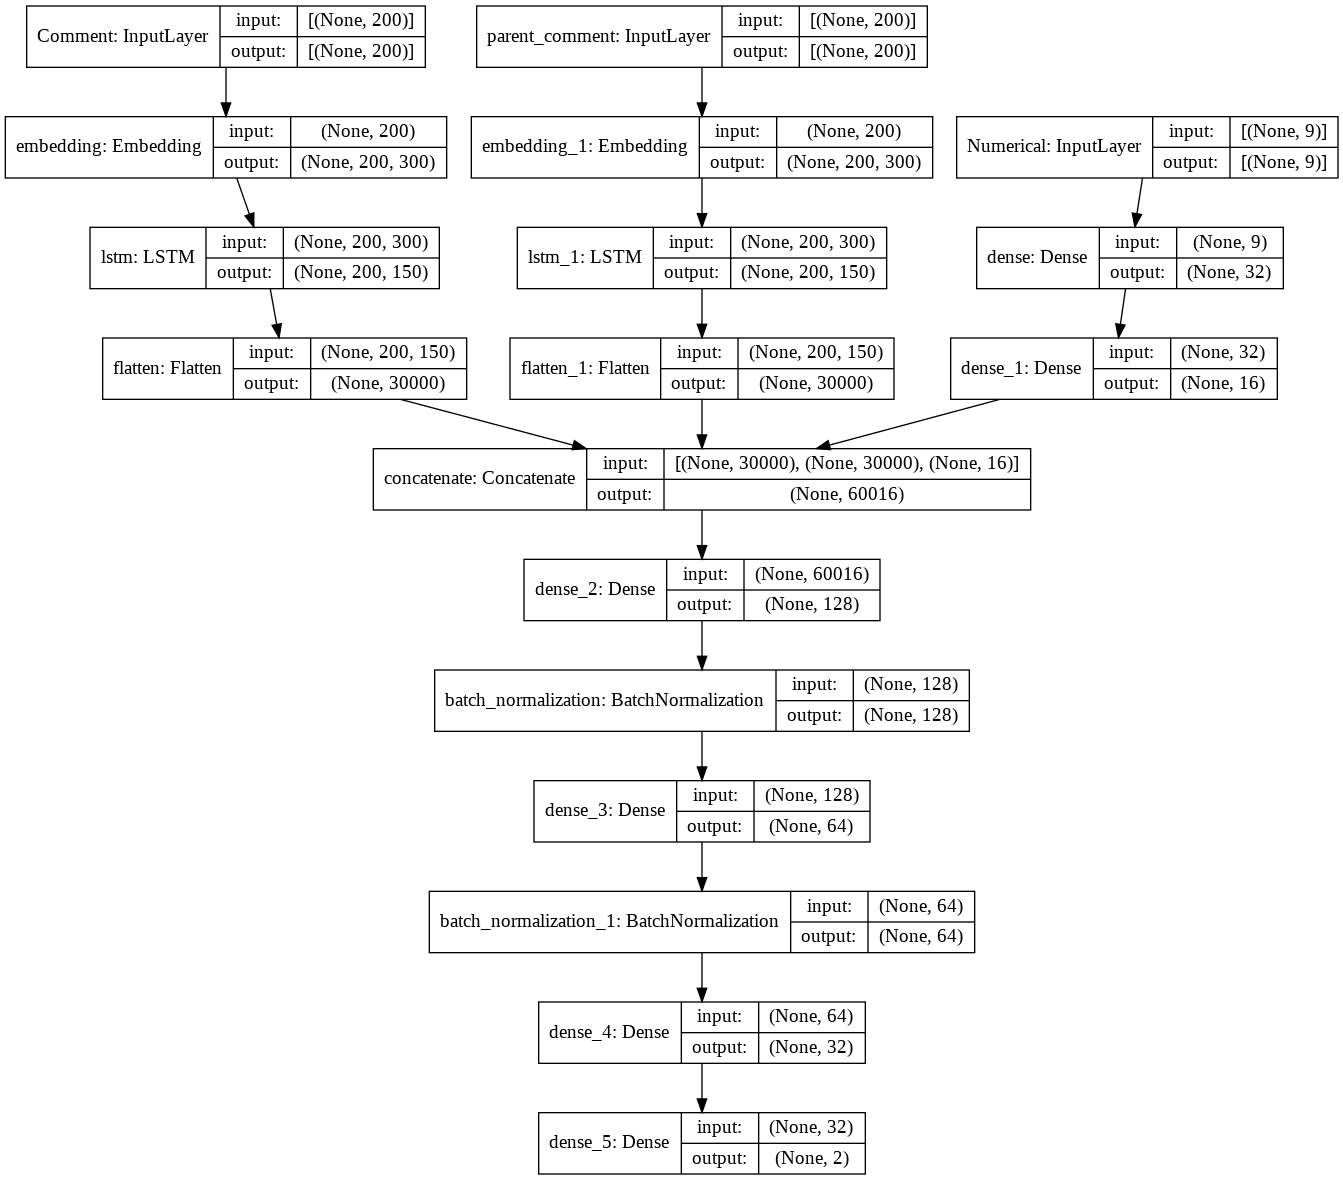

In [47]:

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [48]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [50]:
hitory=model.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 260s 183ms/step - loss: 1.8344 - accuracy: 0.6518 - val_loss: 3.9281 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 255s 184ms/step - loss: 1.1634 - accuracy: 0.6954 - val_loss: 1.6174 - val_accuracy: 0.5000

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.9326 - accuracy: 0.7102 - val_loss: 0.8923 - val_accuracy: 0.5260

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.7389 - accuracy: 0.7202 - val_loss: 1.1232 - val_accuracy: 0.6536

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6549 - accuracy: 0.7276 - val_loss: 0.6957 - val_accuracy: 0.6697

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6063 - accuracy: 0.7336 - val_loss: 0.9993 - val_accuracy: 0.6539

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.5765 - accuracy: 0.7396 - val_loss: 0.6100 - val_accuracy: 0.7077

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6959 - accuracy: 0.6884 - val_loss: 0.8172 - val_accuracy: 0.5311

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.7952 - accuracy: 0.6072 - val_loss: 0.9228 - val_accuracy: 0.5353

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 10/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6532 - accuracy: 0.6519 - val_loss: 0.7369 - val_accuracy: 0.6069

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6430 - accuracy: 0.6598 - val_loss: 0.8732 - val_accuracy: 0.5225

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 12/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6114 - accuracy: 0.6766 - val_loss: 0.6095 - val_accuracy: 0.6795

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.6060 - accuracy: 0.6801 - val_loss: 0.6228 - val_accuracy: 0.6664

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 14/50
1382/1382 [==============================] - 255s 185ms/step - loss: 0.5911 - accuracy: 0.6890 - val_loss: 0.6308 - val_accuracy: 0.6295

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.5874 - accuracy: 0.6914 - val_loss: 0.6110 - val_accuracy: 0.6705

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00015: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 00015: early stopping


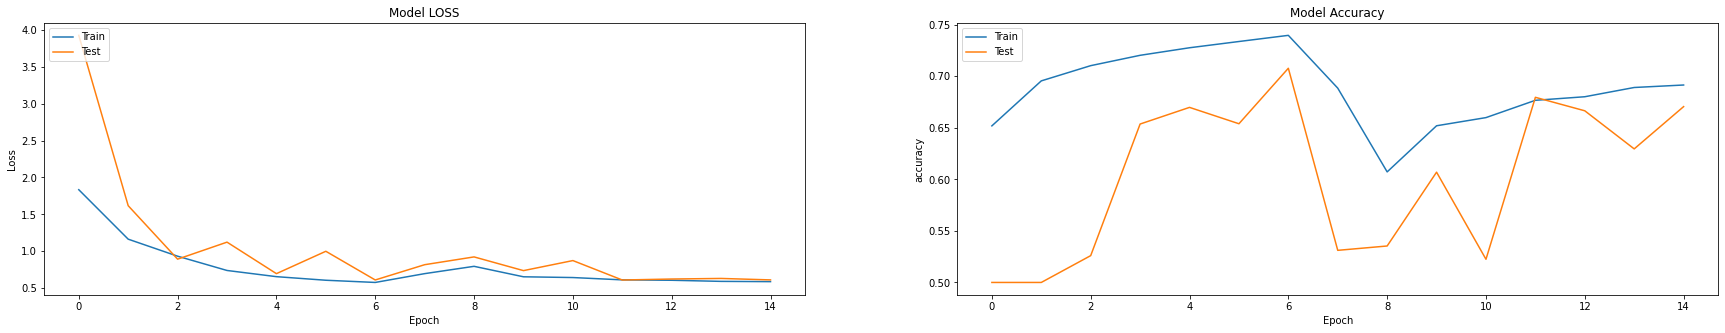

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model:-2

(b)  LSTM layer with Embedding with glove weight

In [46]:
tf.keras.backend.clear_session()

In [49]:
from tensorflow.keras.layers import concatenate
def LSTM_Model_glove(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [50]:
model=LSTM_Model_glove(comm_len,token_com,par_comm_len,token_par)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     108750300   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     56921400    parent_comment[0][0]             
______________________________________________________________________________________________

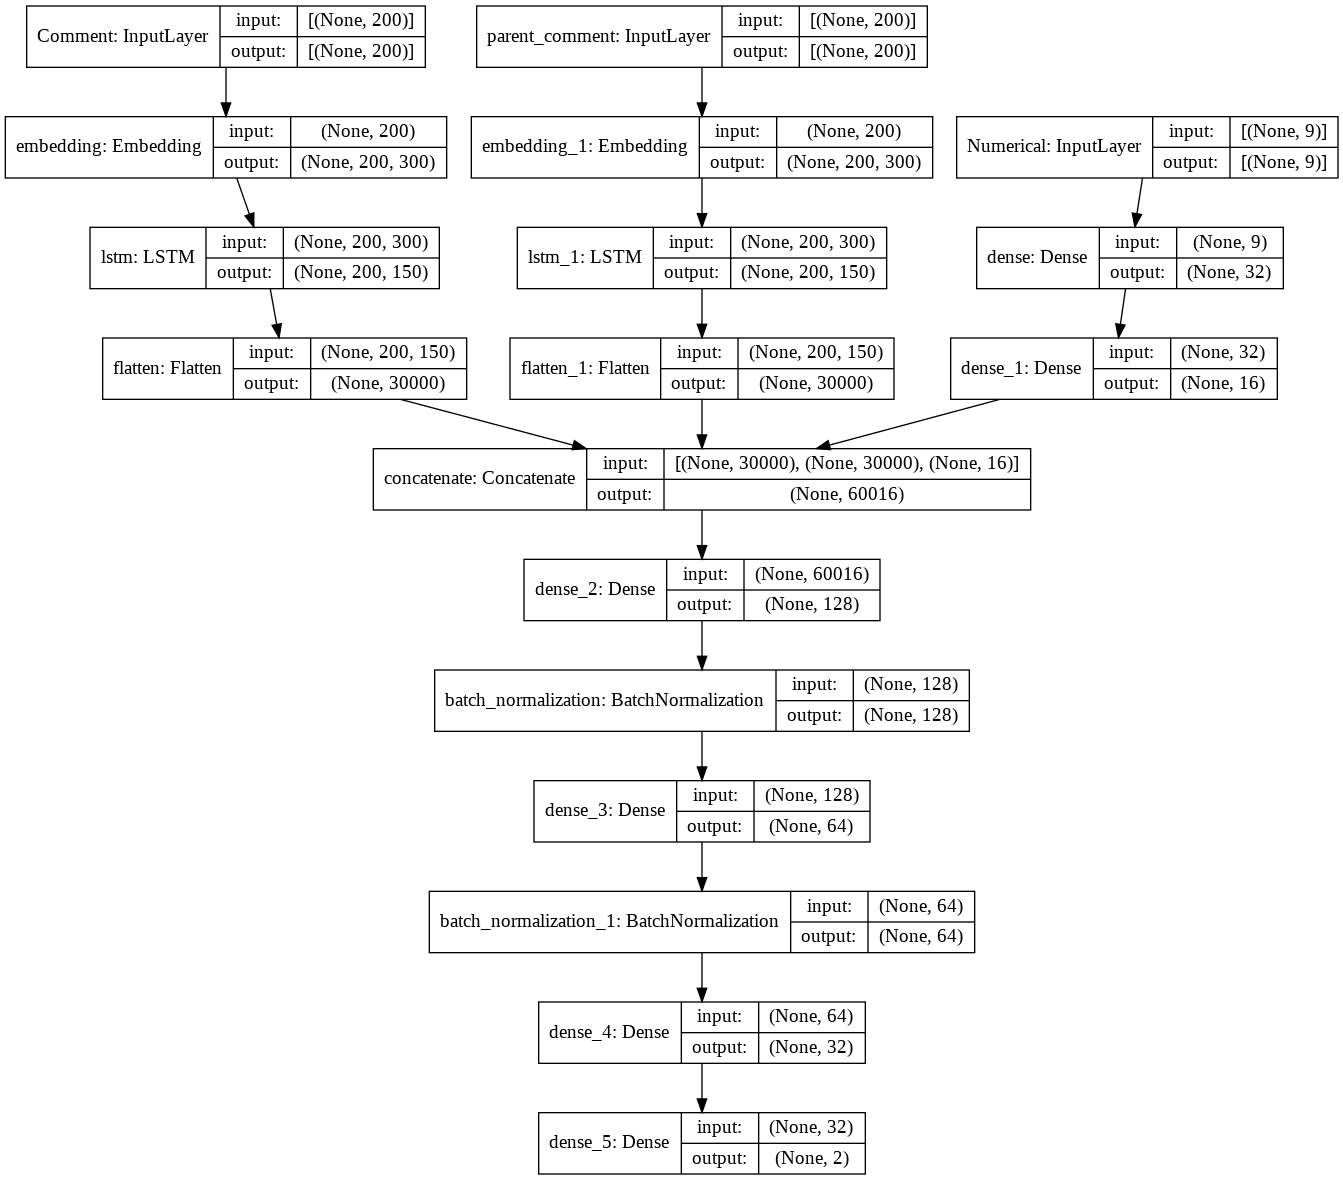

In [51]:

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [52]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [53]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [54]:
hitory=model.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 182s 126ms/step - loss: 1.5345 - accuracy: 0.6864 - val_loss: 1.1756 - val_accuracy: 0.7098

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 173s 125ms/step - loss: 1.0142 - accuracy: 0.7109 - val_loss: 6.9704 - val_accuracy: 0.5000

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.8386 - accuracy: 0.7180 - val_loss: 1.4401 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5666 - accuracy: 0.7305 - val_loss: 0.9024 - val_accuracy: 0.5528

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5547 - accuracy: 0.7347 - val_loss: 2.7911 - val_accuracy: 0.5000

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 6/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5261 - accuracy: 0.7400 - val_loss: 0.5449 - val_accuracy: 0.7250

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5231 - accuracy: 0.7414 - val_loss: 0.5404 - val_accuracy: 0.7318

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5213 - accuracy: 0.7433 - val_loss: 0.5438 - val_accuracy: 0.7328

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5198 - accuracy: 0.7442 - val_loss: 0.6269 - val_accuracy: 0.6929

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.5183 - accuracy: 0.7458 - val_loss: 0.5427 - val_accuracy: 0.7334

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5170 - accuracy: 0.7469 - val_loss: 0.5804 - val_accuracy: 0.7101

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5158 - accuracy: 0.7475 - val_loss: 1.2751 - val_accuracy: 0.5361

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 13/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5080 - accuracy: 0.7500 - val_loss: 0.6273 - val_accuracy: 0.6936

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5068 - accuracy: 0.7505 - val_loss: 0.5761 - val_accuracy: 0.7172

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 15/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5043 - accuracy: 0.7519 - val_loss: 0.5433 - val_accuracy: 0.7278

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5027 - accuracy: 0.7520 - val_loss: 0.5391 - val_accuracy: 0.7282

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
Epoch 17/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5015 - accuracy: 0.7534 - val_loss: 0.5323 - val_accuracy: 0.7335

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5013 - accuracy: 0.7536 - val_loss: 0.5319 - val_accuracy: 0.7337

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 19/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5011 - accuracy: 0.7531 - val_loss: 0.5351 - val_accuracy: 0.7331

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.5011 - accuracy: 0.7532 - val_loss: 0.5324 - val_accuracy: 0.7335

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
Epoch 21/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5004 - accuracy: 0.7541 - val_loss: 0.5337 - val_accuracy: 0.7333

Epoch 00021: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 22/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.5005 - accuracy: 0.7535 - val_loss: 0.5333 - val_accuracy: 0.7336

Epoch 00022: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.103515488575795e-07.
Epoch 23/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.4998 - accuracy: 0.7541 - val_loss: 0.5334 - val_accuracy: 0.7334

Epoch 00023: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 24/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.4995 - accuracy: 0.7547 - val_loss: 0.5338 - val_accuracy: 0.7333

Epoch 00024: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5258788721439487e-07.
Epoch 25/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.4997 - accuracy: 0.7540 - val_loss: 0.5337 - val_accuracy: 0.7334

Epoch 00025: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 26/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.4996 - accuracy: 0.7541 - val_loss: 0.5336 - val_accuracy: 0.7334

Epoch 00026: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.814697180359872e-08.
Epoch 00026: early stopping


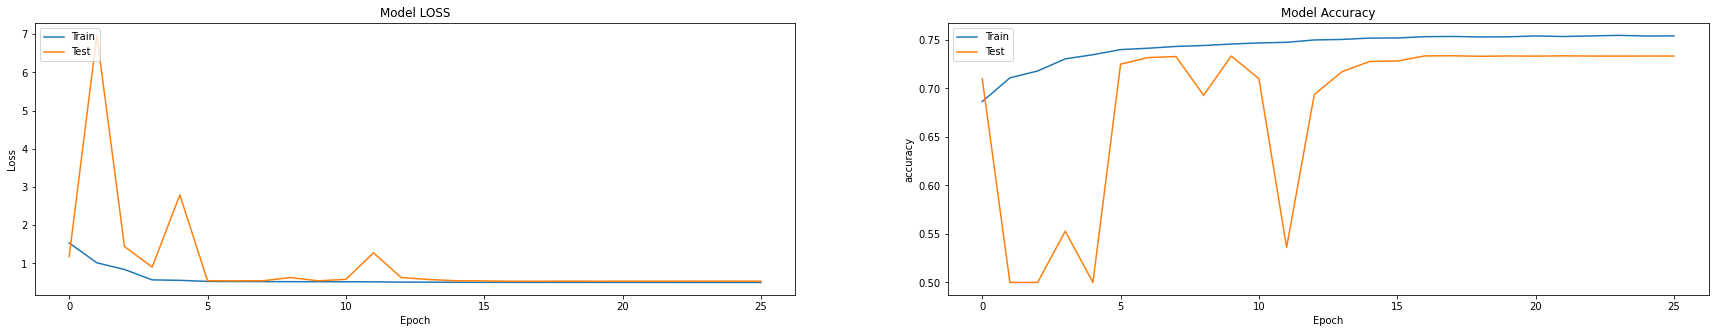

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model:-3

(c) LSTM layer with Embedding with Fast text weight

In [44]:
tf.keras.backend.clear_session()

In [45]:
from tensorflow.keras.layers import concatenate
def LSTM_Model_fast(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm_fast],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm_fast],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [46]:
model=LSTM_Model_fast(comm_len,token_com,par_comm_len,token_par)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     108750300   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     56921400    parent_comment[0][0]             
______________________________________________________________________________________________

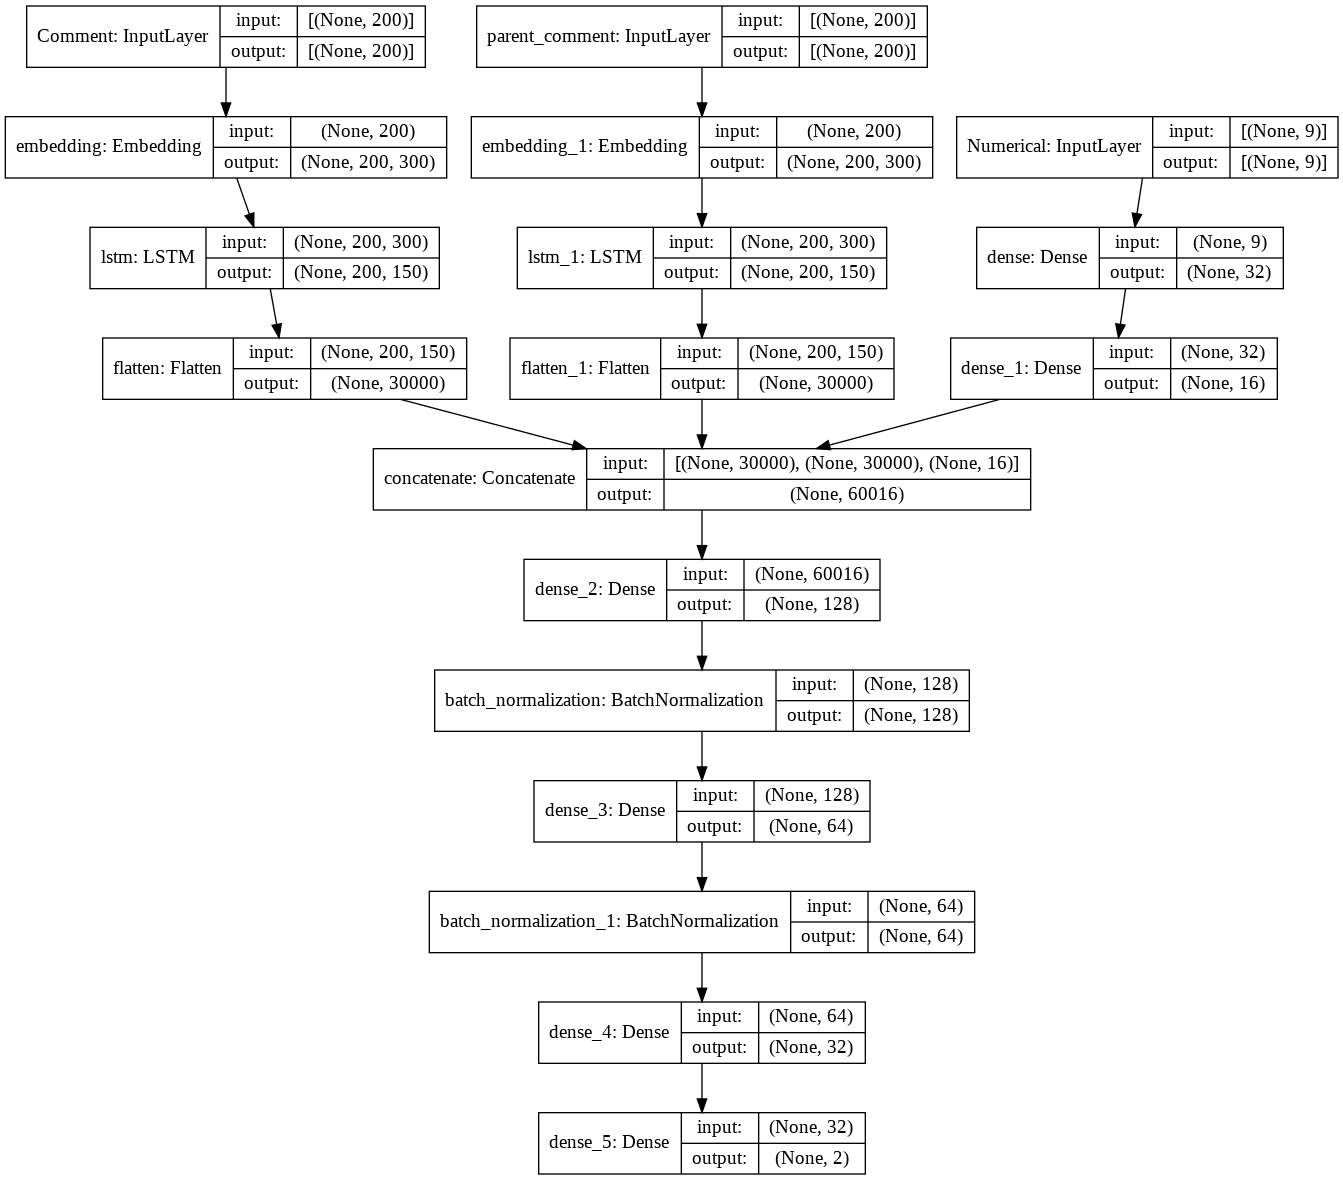

In [47]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,rankdir='TB')

In [48]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 5,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [50]:
hitory=model.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 183s 127ms/step - loss: 1.6829 - accuracy: 0.6836 - val_loss: 3.2730 - val_accuracy: 0.5001

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 174s 126ms/step - loss: 1.0614 - accuracy: 0.7126 - val_loss: 1.2035 - val_accuracy: 0.5793

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.7823 - accuracy: 0.7233 - val_loss: 1.0533 - val_accuracy: 0.5023

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.6893 - accuracy: 0.7292 - val_loss: 2.0318 - val_accuracy: 0.5002

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.5396 - accuracy: 0.7413 - val_loss: 0.5534 - val_accuracy: 0.7360

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.5325 - accuracy: 0.7450 - val_loss: 0.7760 - val_accuracy: 0.6060

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.5282 - accuracy: 0.7481 - val_loss: 0.8839 - val_accuracy: 0.5648

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 8/50
1382/1382 [==============================] - 174s 126ms/step - loss: 0.5047 - accuracy: 0.7541 - val_loss: 0.5330 - val_accuracy: 0.7356

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.5025 - accuracy: 0.7547 - val_loss: 0.5304 - val_accuracy: 0.7369

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.5007 - accuracy: 0.7562 - val_loss: 0.5863 - val_accuracy: 0.7066

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4988 - accuracy: 0.7569 - val_loss: 0.5264 - val_accuracy: 0.7396

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4976 - accuracy: 0.7586 - val_loss: 0.5282 - val_accuracy: 0.7395

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4966 - accuracy: 0.7589 - val_loss: 0.5507 - val_accuracy: 0.7331

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 14/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4897 - accuracy: 0.7614 - val_loss: 0.5440 - val_accuracy: 0.7292

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4891 - accuracy: 0.7623 - val_loss: 0.5271 - val_accuracy: 0.7389

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00015: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 16/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4864 - accuracy: 0.7634 - val_loss: 0.5234 - val_accuracy: 0.7399

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4859 - accuracy: 0.7635 - val_loss: 0.5264 - val_accuracy: 0.7388

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.4858 - accuracy: 0.7635 - val_loss: 0.5251 - val_accuracy: 0.7387

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
Epoch 19/50
1382/1382 [==============================] - 175s 127ms/step - loss: 0.4840 - accuracy: 0.7647 - val_loss: 0.5313 - val_accuracy: 0.7377

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.4834 - accuracy: 0.7651 - val_loss: 0.5296 - val_accuracy: 0.7374

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
Epoch 21/50
1382/1382 [==============================] - 175s 126ms/step - loss: 0.4830 - accuracy: 0.7649 - val_loss: 0.5286 - val_accuracy: 0.7383

Epoch 00021: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 00021: early stopping


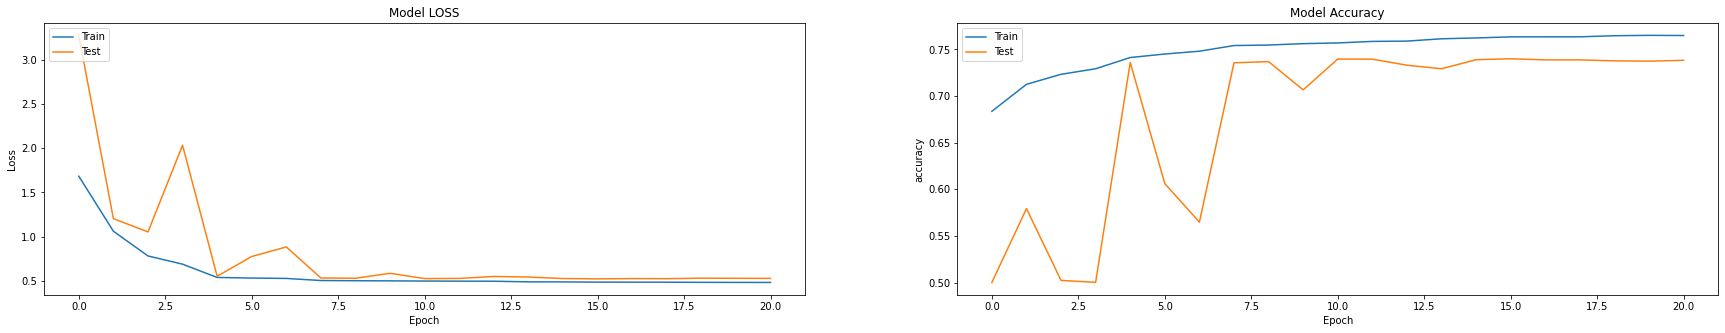

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()